# Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import bs4 as bs
import pickle
import requests
import time
import lxml
from datetime import datetime, timedelta

import yfinance as yf
import stockstats

import unicodedata
import json
from textblob import TextBlob

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest,VotingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score

In [2]:
target="MSFT"

# Read Data

In [3]:
stock_without_absolute = pd.read_pickle('./data/'+target+'/stock_without_absolute.pkl')
stock_with_absolute = pd.read_pickle('./data/'+target+'/stock_with_absolute.pkl')

label_abs_1d = pd.read_pickle('./data/'+target+'/label_abs_1d.pkl')
label_abs_7d = pd.read_pickle('./data/'+target+'/label_abs_7d.pkl')
label_abs_30d = pd.read_pickle('./data/'+target+'/label_abs_30d.pkl')

label_value_1d = pd.read_pickle('./data/'+target+'/label_value_1d.pkl')
label_value_7d = pd.read_pickle('./data/'+target+'/label_value_7d.pkl')
label_value_30d = pd.read_pickle('./data/'+target+'/label_value_30d.pkl')


In [4]:
scaler = MinMaxScaler()
stock_corr = scaler.fit_transform(stock_with_absolute)
stock_corr = pd.DataFrame(stock_corr,columns=stock_with_absolute.columns)
stock_corr.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

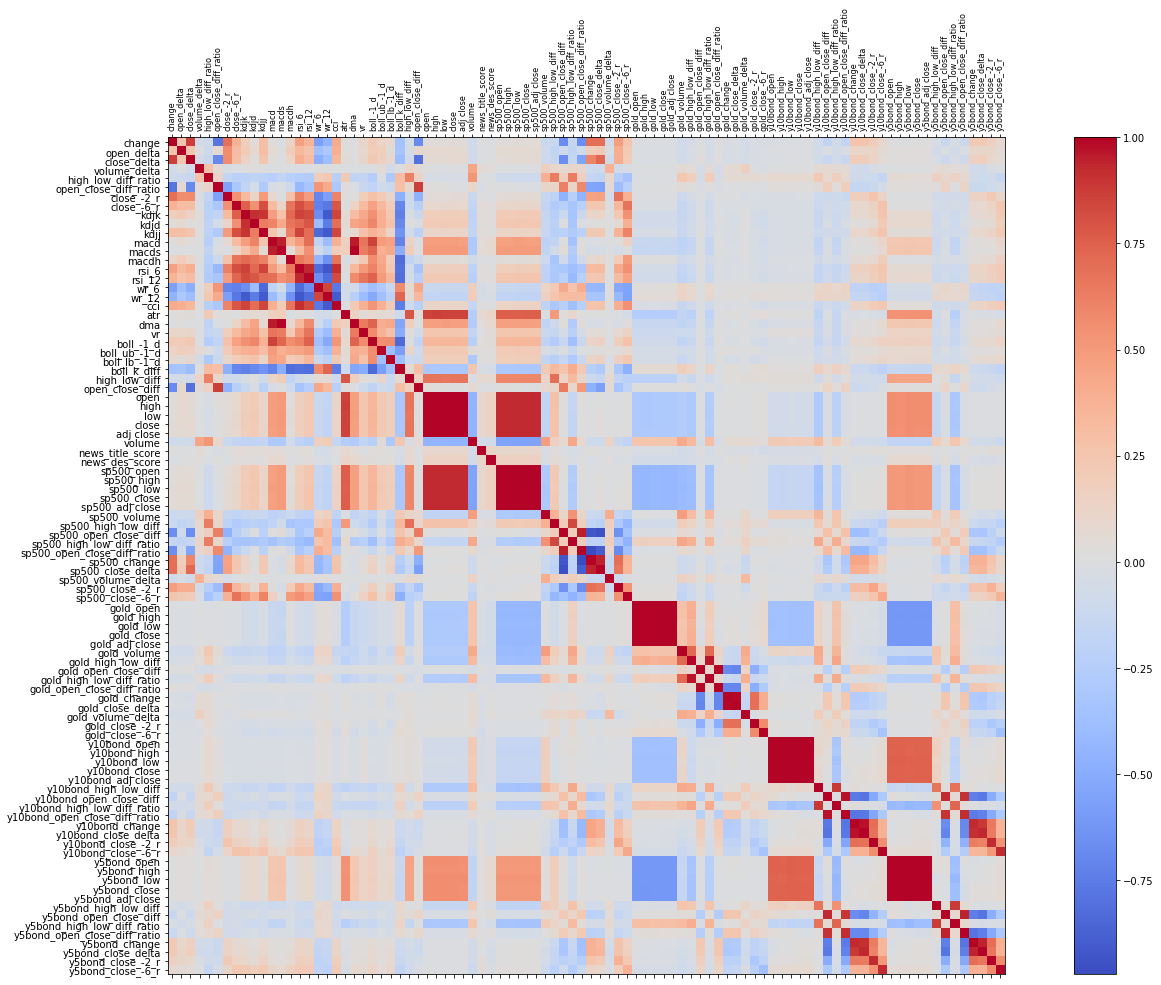

In [6]:
f = plt.figure(figsize=(25, 15))
plt.matshow(stock_corr.corr(), fignum=f.number, cmap='coolwarm')
plt.xticks(range(stock_with_absolute.shape[1]), stock_with_absolute.columns, fontsize=8, rotation=90)
plt.yticks(range(stock_with_absolute.shape[1]), stock_with_absolute.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

# Result Evaluation

In [7]:
def create_grid_model(classifier, param_grid):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
    grid_model = GridSearchCV(classifier, param_grid=param_grid, cv=cv, n_jobs=-1,verbose=1, scoring='accuracy')
    return grid_model




In [8]:
def result(grid_model, train_data, predicted_test, test_label, predicted_train, train_label, file_name, 
           decision_function, clf_name="Classifier"):
    print("Results for ", clf_name, ": ")
    print()
    print("The best parameters are %s" % (grid_model.best_params_))
    acc_train = accuracy_score(train_label, predicted_train)
    acc_test = accuracy_score(test_label, predicted_test)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Validation Accuracy   %0.3f" % (grid_model.best_score_))
    print("The Test Accuracy   %0.3f" % (acc_test ))
    
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        test_label_roc = np.zeros((len(test_label),2) )
        for i,v in enumerate(test_label):
            if v > 0.5:
                test_label_roc[i,1] = 1
            else:
                test_label_roc[i,0] = 1
    
    
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        print("AUC ROC : %0.3f" %( roc_auc_score(test_label_roc, decision_function) ))
    else:
        print("AUC ROC : %0.3f" %( roc_auc_score(test_label, decision_function) ))

    print("The mean training time of %f" % (np.mean(grid_model.cv_results_['mean_fit_time'], axis=0)) )
    print("The mean test time of %f" % (np.mean(grid_model.cv_results_['mean_score_time'], axis=0)) )
    # confusion matrix
    print("confusion matrix / precision recall scores")
    print ( confusion_matrix(test_label, predicted_test) )
    print ( classification_report(test_label, predicted_test) )
    
    #feature importance
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(train_data.columns, grid_model.best_estimator_.feature_importances_):
        feats[feature] = importance #add the name/value pair 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances = importances.sort_values(by='Gini-importance', ascending=False)
    print(importances.head(7)) # print the top 7 features with greater importance
    
    f = open(file_name+'.txt','w')
    f.write("The best parameters are %s\n"% (grid_model.best_params_))
    f.write("The Train Accuracy %0.3f\n" % (acc_train))
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label_roc, decision_function) ))
    else:
        f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label, decision_function) ))

    f.write("The Validation Accuracy %0.3f\n" % (grid_model.best_score_))
    f.write("The Test Accuracy %0.3f\n" % (acc_test ))
    f.write( str(confusion_matrix(test_label, predicted_test)) + "\n")
    f.write( str(classification_report(test_label, predicted_test)) + "\n\n")
    f.write(json.dumps(feats))
    f.close()
    
    importances.to_csv(file_name+'.csv')
    
    pass

In [9]:
best_1d_model_param = None
best_7d_model_param = None
best_30d_model_param = None

# Random Forest Classifier

In [ ]:
# 改這些地方： train_data, label, filename, clfname

In [ ]:
# stock_with_absolute, predict 1 day trend 
rfc = RandomForestClassifier() # classifier
max_depth = [2, 4, 8, 10, 20]
n_estimators = [100, 500, 1000]
max_features = [2 ,'sqrt']
# min_samples_split = [None, 10, 50]

# param to grid search
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# train data and label
train_data = stock_with_absolute
label = label_abs_1d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/rfc_with_ABS_pred_1_d", decision_function, clf_name="RandomForest")
best_1d_model_param = rfc_model.best_params_

In [ ]:
# # stock_without_absolute, predict 1 day trend 
# rfc = RandomForestClassifier() # classifier
# max_depth = [2, 4, 8, 10, 20]
# n_estimators = [100, 500, 1000]
# max_features = [2 ,'sqrt']
# # min_samples_split = [None, 10, 50]

# # param to grid search
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_1d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/rfc_without_ABS_pred_1_d", decision_function, clf_name="RandomForest")

In [ ]:
# stock_with_absolute, predict 7 day trend 
rfc = RandomForestClassifier() # classifier
max_depth = [2, 4, 8, 10, 20]
n_estimators = [100, 500, 1000]
max_features = [2 ,'sqrt']
# min_samples_split = [None, 10, 50]

# param to grid search
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# train data and label
train_data = stock_with_absolute
label = label_abs_7d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/rfc_with_ABS_pred_7_d", decision_function, clf_name="RandomForest")
best_7d_model_param = rfc_model.best_params_

In [ ]:
# # stock_without_absolute, predict 7 day trend 
# rfc = RandomForestClassifier() # classifier
# max_depth = [2, 4, 8, 10, 20]
# n_estimators = [100, 500, 1000]
# max_features = [2 ,'sqrt']
# # min_samples_split = [None, 10, 50]

# # param to grid search
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_7d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/rfc_without_ABS_pred_7_d", decision_function, clf_name="RandomForest")

In [10]:
# stock_with_absolute, predict 30 day trend 
rfc = RandomForestClassifier() # classifier
max_depth = [2, 4, 8, 10, 20]
n_estimators = [100, 500, 1000]
max_features = [2 ,'sqrt']
# min_samples_split = [None, 10, 50]

# param to grid search
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# train data and label
train_data = stock_with_absolute
label = label_abs_30d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/rfc_with_ABS_pred_30_d", decision_function, clf_name="RandomForest")
best_30d_model_param = rfc_model.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


Results for  RandomForest : 

The best parameters are {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 1000}
The Train Accuracy  1.000
The Validation Accuracy   0.898
The Test Accuracy   0.908
AUC ROC : 0.959
The mean training time of 5.490444
The mean test time of 0.124987
confusion matrix / precision recall scores
[[157   9]
 [ 14  69]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       166
           1       0.88      0.83      0.86        83

    accuracy                           0.91       249
   macro avg       0.90      0.89      0.89       249
weighted avg       0.91      0.91      0.91       249

            Gini-importance
high               0.032883
adj close          0.031735
close              0.030234
open               0.029317
low                0.029197
sp500_high         0.025549
macds              0.025178


In [ ]:
# # stock_without_absolute, predict 30 day trend 
# rfc = RandomForestClassifier() # classifier
# max_depth = [2, 4, 8, 10, 20]
# n_estimators = [100, 500, 1000]
# max_features = [2 ,'sqrt']
# # min_samples_split = [None, 10, 50]

# # param to grid search
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_30d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/rfc_without_ABS_pred_30_d", decision_function, clf_name="RandomForest")

In [ ]:
best_list = [best_1d_model_param, best_7d_model_param,  best_30d_model_param]
labels = [label_abs_1d, label_abs_7d, label_abs_30d]
file_name = ["RFC_1d", "RFC_7d", "RFC_30d"]

for index, best_parameters in enumerate(best_list):
    print(best_parameters)
    rfc = RandomForestClassifier(**best_parameters)

    # train data and label
    train_data = stock_with_absolute
    label = labels[index]

    X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rfc.fit(X_train, y_train)

    predicted_test = rfc.predict(X_test)
    predicted_train = rfc.predict(X_train)

    acc_train = accuracy_score(y_train, predicted_train)
    acc_test = accuracy_score(y_test, predicted_test)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Test Accuracy   %0.3f" % (acc_test ))
    pickle.dump(rfc, open('./backend/'+target+'/RF/'+file_name[index]+'.pkl','wb'))

In [11]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.ensemble
import lime
import lime.lime_tabular
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
np.random.seed(1)
import shap

In [12]:
scaler = MinMaxScaler()
train_data = stock_with_absolute
label = label_abs_30d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
train = pd.DataFrame(X_train, columns=stock_with_absolute.columns)

In [16]:
test = pd.DataFrame(X_test, columns=stock_with_absolute.columns)

In [17]:
# load JS visualization code to notebook
shap.initjs()
rfc = RandomForestClassifier(**best_30d_model_param)

rfc.fit(train, y_train)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(rfc, train)
shap_values = explainer.shap_values(test, check_additivity=False)

Passing 2232 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 497/498 [30:19<00:03]        

SHAPError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.118998, while the model output was 0.112989. If this difference is acceptable you can set check_additivity=False to disable this check.

In [18]:
shap_values = explainer.shap_values(test, check_additivity=False)

100%|===================| 497/498 [30:00<00:03]        

In [29]:
explainer.expected_value

array([0.65143273, 0.34856727])

In [34]:
shap.multioutput_decision_plot(
     explainer.expected_value, shap_values, test.values ,link='logit'
)

ValueError: The base_values and shap_values args expect lists.